<h1 align='center'>How efficient was emergency response to Hurricane Harvey?</h1>
<h2 align='center'>Michael Greene 4766783 gree1886</h2>
<h3 align='center'>Data from api.harveyneeds.org/api/v1</h3><br><br>
<h1>1. Exploring the data</h1>
<h2>1.1 Request the data</h2>

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# request the needs, products, and shelters data from the API
# cast response body as JSON, parse as pandas DF
d1 = requests.get('https://api.harveyneeds.org/api/v1/needs').json()
needsdf = pd.DataFrame(list(d1.items())[0][1])

# most needs aren't a specific product so this DF wont be used much
d2 = requests.get('https://api.harveyneeds.org/api/v1/products').json()
productsdf = pd.DataFrame(list(d2.items())[0][1])

d3 = requests.get('https://api.harveyneeds.org/api/v1/shelters').json()
sheltersdf = pd.DataFrame(list(d3.items())[0][1])
needsdf.head()

,anything_else_you_would_like_to_tell_us,are_supplies_needed,are_volunteers_needed,cleanPhone,contact_for_this_location_name,contact_for_this_location_phone_number,id,last_updated,latitude,location_address,location_name,longitude,needs,tell_us_about_the_supply_needs,tell_us_about_the_volunteer_needs,updatedAt,updated_at,updated_by
0,Mobile Hospital,True,True,None,Dr. Candice Dunn,(409) 771-7812,83210,None,29.468127,"3800 Baker Dr, Dickinson, TX 77539",Dickinson High School,-95.03095,None,"baby items, adult diapers, water, nonperishabl...","Friday, August 31st and Saturday, Sept. 1st, 1...",None,None,Taylor
1,"St. Laurence is not needed as a shelter, so we...",True,True,None,None,(281) 980-9812,83299,None,NaN,"3100 Sweetwater Blvd, Sugar Land, Texas 77479",St. Laurence Catholic Church,NaN,None,None,None,None,None,None
2,Organizing teams to help with cleanup,True,True,None,None,(281) 427-1725,83302,None,NaN,"600 W Sterling St, Baytown, TX",Memorial Baptist Church,NaN,None,None,None,None,None,None
3,9/6 - We are open as a distribution center tod...,True,True,None,,(281) 395-5433,83219,None,NaN,"26189 Westheimer Pkwy, Katy, TX 77494",Life Church Katy,NaN,None,unknown,unknown,None,None,
4,None,True,True,5551234567,Lauren Duplessis,5551234567,83301,2017-09-05T22:23:20-05:00,NaN,"1 NRG Park, Houston, TX 77054",NRG Center,NaN,[Sign up at: https://volunteer.bakerripley.org...,Desperately need men's pants and men's shoes,Sign up at: https://volunteer.bakerripley.org/...,2017-09-05T22:23:20-05:00,2017-09-05T22:23:20-05:00,None


<h2>1.2 Visualizing the needs and shelters</h2>

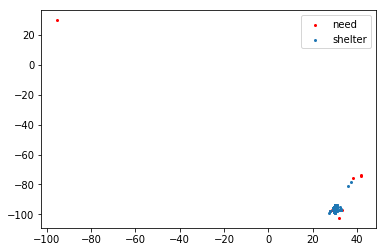

In [2]:
# plot the needs and shelters
ax = plt.figure().add_subplot(111)
ax.scatter(needsdf['latitude'], needsdf['longitude'], s=4, c='red', label='need', )
ax.scatter(sheltersdf['latitude'], sheltersdf['longitude'], s=4, label='shelter')
plt.legend()
plt.show()

<h3><i>An outlier can be seen by inspection, so it is removed

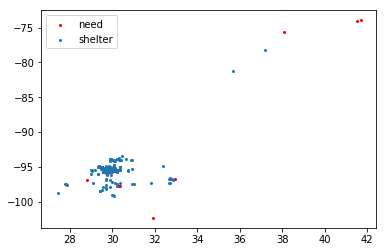

In [3]:
# remove the outlier(s) and replot
ax2 = plt.figure().add_subplot(111)

processed = needsdf.drop(20) # only do this to make the plotting more informative
needs = needsdf[['latitude', 'longitude']].dropna()
n2 = needs[needs['latitude'] > 29]
n3 = n2[n2['latitude'] < 31]
n4 = n3[n3['longitude'] > -99]

shelters = sheltersdf[['latitude', 'longitude']].dropna()
s2 = shelters[shelters['latitude'] < 35]

ax2.scatter(processed['latitude'], processed['longitude'], s=4, c='red', label='need')
ax2.scatter(shelters['latitude'], shelters['longitude'], s=4, label='shelter')
plt.legend()
plt.show()

<h3><i>This gives a rough estimate of how well the shelters are distributed throughout the affected area</i></h3>
<h2>1.3 Needs by category</h2>

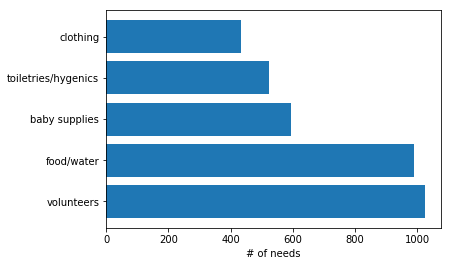

In [4]:
import numpy as np
idx = 'tell_us_about_the_supply_needs' # column name of interest

# get the number of needs matching certain categories
needVolunteers = needsdf[needsdf['are_volunteers_needed'] == True].size # keywords could affect the relative counts slightly
needFoods = needsdf[needsdf[idx].str.contains("food|perishable|water") == True].size
needBabySups = needsdf[needsdf[idx].str.contains("baby|diaper") == True].size
needHygenics = needsdf[needsdf[idx].str.contains("hygiene|cleaning") == True].size
needClothes = needsdf[needsdf[idx].str.contains("clothing|shoes|clothes") == True].size

# compare the number of needs in each category
vals = [needVolunteers, needFoods, needBabySups, needHygenics, needClothes]
labels = ('volunteers', 'food/water', 'baby supplies', 'toiletries/hygenics', 'clothing')
pos = np.arange(len(vals))

plt.barh(pos, vals, align='center')
plt.yticks(pos, labels)
plt.xlabel('# of needs')
plt.show()

<h1>2. Creating the models</h1>
<h2>2.1 Find the number of clusters using DBSCAN</h2>
<h3><i>DBSCAN was chosen because it is unsupervised, and can find the number of natural clusters that exist in the data. Eps = 0.1 was guessed by inspecting the graph of Needs, as was min_samples = 3</i></h3>

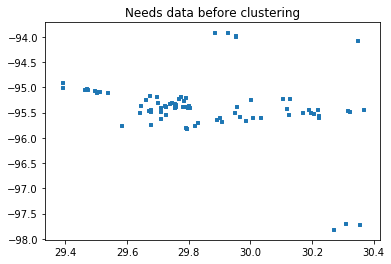

In [5]:
from sklearn.cluster import DBSCAN
dbmodel = DBSCAN(eps=0.1, min_samples=3).fit(n3)
core_samples_mask = np.zeros_like(dbmodel.labels_, dtype=bool)
core_samples_mask[dbmodel.core_sample_indices_] = True

# Number of clusters in labels, ignoring noise if present.
dblabels = dbmodel.labels_
nClusters = len(set(dblabels)) - (1 if -1 in dblabels else 0)

plt.scatter(n3['latitude'], n3['longitude'], 9, marker=',')
plt.title("Needs data before clustering")
plt.show()

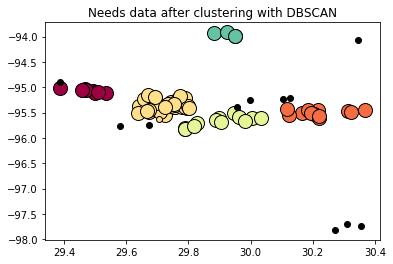

In [6]:
# Black is used to represent noise
dbunique_labels = set(dblabels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(dbunique_labels))]
for k, col in zip(dbunique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (dblabels == k)

    xy = n3[class_member_mask & core_samples_mask]
    plt.plot(xy['latitude'], xy['longitude'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = n3[class_member_mask & ~core_samples_mask]
    plt.plot(xy['latitude'], xy['longitude'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Needs data after clustering with DBSCAN')
plt.show()

<h3><i>Based on this clustering, we should look for 5 clusters when training other models</i></h3>

<h2>2.2 find the "best" clustering using Agglomerative Hierarchical clustering</h2>
<h3><i>Agglomerative Hierarchical was chosen over other unsupervised methods because it tends to do well when classes are imbalanced and have varying densities, such as in the needs data<br><br>
Euclidean Distance evaluates similarities, and Wards method merges clusters</i></h3>

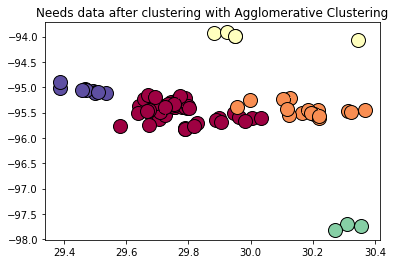

In [7]:
from sklearn.cluster import AgglomerativeClustering
acmodel = AgglomerativeClustering(nClusters).fit(n3) # similarity by euclidean distance, Wards method for merging clusters

# Number of clusters in labels, ignoring noise if present.
aclabels = acmodel.labels_
# Black removed and is used for noise instead.
acunique_labels = set(aclabels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(acunique_labels))]
for k, col in zip(acunique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (aclabels == k)

    xy = n3[class_member_mask]
    plt.plot(xy['latitude'], xy['longitude'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = n3[class_member_mask]
    plt.plot(xy['latitude'], xy['longitude'], ',', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Needs data after clustering with Agglomerative Clustering')
plt.show()

<h2>2.3 Cluster Needs data with kMeans to find the centroids of each cluster</h2>

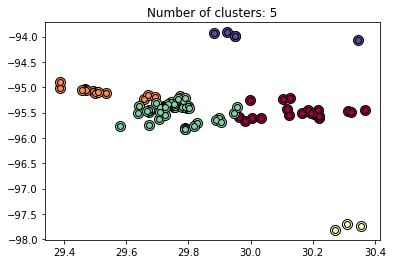

In [8]:
from sklearn.cluster import KMeans
kmmodel = KMeans(nClusters).fit(n3) # default to KMeans++ initialization

# Number of clusters in labels, ignoring noise if present.
kmlabels = kmmodel.labels_
# Black removed and is used for noise instead.
kmunique_labels = set(kmlabels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(kmunique_labels))]
for k, col in zip(kmunique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (kmlabels == k)

    xy = n3[class_member_mask]
    plt.plot(xy['latitude'], xy['longitude'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = n3[class_member_mask]
    plt.plot(xy['latitude'], xy['longitude'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Number of clusters: %d' % nClusters)
plt.show()

<h2>2.4 Cluster the Shelter data as well</h2>
<h3>2.4.1 Cluster with kMeans to compare centroids</h3>

<h3><i>kMeans++ was used to initialize the cluster centroids which maximizes distance between centroids when initialized</i></h3>

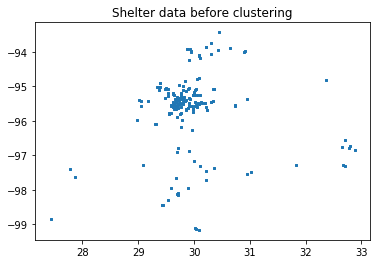

In [9]:
plt.scatter(s2['latitude'], s2['longitude'], 4, marker=',')
plt.title("Shelter data before clustering")
plt.show()

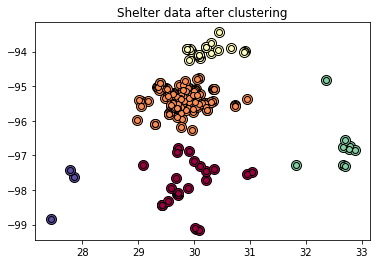

In [10]:
kmSHmodel = KMeans(nClusters).fit(s2) # default to KMeans++ initialization

# Number of clusters in labels, ignoring noise if present.
kmslabels = kmSHmodel.labels_
# Black removed and is used for noise instead.
kmunique_labels = set(kmslabels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(kmunique_labels))]
for k, col in zip(kmunique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (kmslabels == k)

    xy = s2[class_member_mask]
    plt.plot(xy['latitude'], xy['longitude'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = s2[class_member_mask]
    plt.plot(xy['latitude'], xy['longitude'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Shelter data after clustering')
plt.show()

<h3>2.4.2 Cluster shelters with Agglomerative Hierarchical- this will be used to compare with the needs AC model predictions</h3>

In [11]:
acSHmodel = AgglomerativeClustering(nClusters).fit(s2)

<h3><i>We can now create a few useful variables to help evauate the efficiency of the shelters</i></h3>

In [12]:
needsCentroids = kmmodel.cluster_centers_
shelterCentroids = kmSHmodel.cluster_centers_

kmlabels = kmmodel.labels_
kmslabels = kmSHmodel.labels_
kmpredlabels = kmmodel.predict(s2)

aclabels = acmodel.labels_
acslabels = acSHmodel.labels_

<h1>3. Model evaluation</h1>
<h2>3.1 Evaluate kMeans model for needs, this will give an idea of how skeptical to be when evaluating shelters against this model</h2>
<h3>3.1.1 Evaluate with Silhouette Score</h3>

In [13]:
from sklearn import metrics
kneedsSil = metrics.silhouette_score(n3, kmlabels)
print("kMeans Silhouette Score: ", kneedsSil)

kMeans Silhouette Score:  0.496676040376


<h3><i>Silhouette score ranges from -1 to 1 with score $<$ 0 indicating high misclassification and 0 indicating overlapping clusters. So a score of 0.5 is not bad</i></h3><br>
<h3>3.1.2 Evaluate needs clustering with kMeans against Agglomerative Clustering</h3>

In [14]:
#first evaluate the Agglomerative Clustering Model
acneedsSil = metrics.silhouette_score(n3, aclabels)
print("Agglomerative Hierarchical Silhouette Score: ", acneedsSil)

Agglomerative Hierarchical Silhouette Score:  0.500913776478


<h3><i>So AC model is pretty good as well. Now compare kMeans to AC</i></h3>

In [15]:
kmAC = metrics.fowlkes_mallows_score(aclabels, kmlabels)
print("kMeans model matches AC by", kmAC*100, "%")

kMeans model matches AC by 79.8591573848 %


<h3><i>Comparing to the kMeans model is a good indicator of how well the shelters are clustered if we accept 80%</i></h3><br>
<h2>3.2 Evaluate the kMeans model for the shelters data</h2>

In [16]:
ksheltSil = metrics.silhouette_score(s2, kmslabels)
print("kMeans Silhouette Score: ", ksheltSil)

kMeans Silhouette Score:  0.645681135428


<h2>3.3 Evaluate Agglomerative Hierarchical model for shelters data</h2>

In [17]:
acsheltSil = metrics.silhouette_score(s2, acslabels)
print("Agglomerative Clustering Silhouette Score: ", acsheltSil)

Agglomerative Clustering Silhouette Score:  0.639810202341


<h2>3.4 Model evaluation summary</h2>

In [18]:
summaryDicts = [{"Dataset":"Needs", "Model":"kMeans", "Silhouette Score":kneedsSil},
               {"Dataset":"Needs", "Model":"AC", "Silhouette Score":acneedsSil},
               {"Dataset":"Shelters", "Model": "kMeans", "Silhouette Score":ksheltSil},
               {"Dataset":"Shelters", "Model":"AC", "Silhouette Score":acsheltSil},
               {"Dataset":"Needs", "Model":"DBSCAN", "Silhouette Score": metrics.silhouette_score(n3, dblabels)}]
summaryDF = pd.DataFrame(summaryDicts)
summaryDF

,Dataset,Model,Silhouette Score
0,Needs,kMeans,0.496676
1,Needs,AC,0.500914
2,Shelters,kMeans,0.645681
3,Shelters,AC,0.639810
4,Needs,DBSCAN,0.457336


<h3><i>In addition, the kMeans labels for the needs data matched the AC labels for about 80% of the data by using Fowlkes-Mallows score. This leads to the conclusion that kMeans is a good approximator for AC so it can be used to compare the needs and shelters clusterings when answering the business problem.</i></h3>

<h1>4 Evaluate the emergency response (answer the business question)</h1>
<h2>4.1 Compare the cluster centroids from kMeans models</h2>
<h3>4.1.1 Graph centroids to visualize</h3>

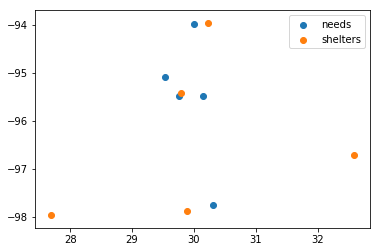

In [19]:
nX = []
sX = []
nY = []
sY = []
for i in range(len(needsCentroids)):
    nX.append(needsCentroids[i][0])
    nY.append(needsCentroids[i][1])
    sX.append(shelterCentroids[i][0])
    sY.append(shelterCentroids[i][1])

plt.scatter(nX, nY, label="needs")
plt.scatter(sX, sY, label="shelters")
plt.legend()
plt.show()

<h3>4.1.2 use Hausdorff distance to determine how close the farthest shortest pair is</h3><br>
<h3><i>Hausdorff distance assigns a nearest neighbor (from the shelters class) to each needs centroid, then returns the greatest distance between the shortest pairs</i></h3>

In [20]:
# use Hausdorff Distance to compute distance between two sets of centroids
import scipy.spatial.distance as hd
hausdorff = hd.directed_hausdorff(needsCentroids, shelterCentroids)[0]
print("greatest distance between shortest pairs: ", hausdorff)

greatest distance between shortest pairs:  0.43122839839342864


In [21]:
#https://gis.stackexchange.com/questions/142326/calculating-longitude-length-in-miles
#This site says 1 degree longitude is roughly 69 miles
hausdorffMiles = 69.0*hausdorff
print("greatest shortest distance in miles: ", hausdorffMiles)

greatest shortest distance in miles:  29.754759489146576


<h3><i>30 miles is the average distance consistently traveled by the least efficiently-placed group</i></h3>
<h2>4.2 Compare predictions from a kMeans model for needs to actual labels from a kMeans model for shelters</h2>

<h3>4.2.1 Using Fowlkes Mallows score gives idea of how many needs have a nearest shelter within the cluster diameter</h3>

In [22]:
print("Fowlkes Mallows: ", metrics.fowlkes_mallows_score(kmslabels, kmpredlabels))

Fowlkes Mallows:  0.609181861939


<h3><i>So 60% of needs have a nearest shelter within their cluster diameter</i></h3>
<h3>4.2.2 now using Rand Index, which gives an estimate of how "accurate" one clustering is when compared to a baseline clustering</h3>

In [23]:
print("Adjusted Rand Index: ", metrics.adjusted_rand_score(kmslabels, kmpredlabels))

Adjusted Rand Index:  0.349978707075


<h2>These measures give an idea of how efficiently the shelters are distributed, and the needs clustering centroids give an idea of where shelters should be located to maximize their reach.</h2>

In [3]:
needs.size

NameError: name 'needs' is not defined